In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu
from scipy import interpolate
import pandas as pd
import math

In [2]:
#If you re-call the method, it will tell you that the files are already downloaded.
shoyu.initialize_standard_library()
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

file already in raman_spectra folder
WATER loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON MONOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
CARBON DIOXIDE loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
FORMIC ACID loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
2-PROPANOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
ETHYL ALCOHOL loaded into the dictionary - shoyu_data_dict.p
file already in raman_spectra folder
DIMETHYL KETONE loaded into the dictionary - shoyu_data_dict.p


['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

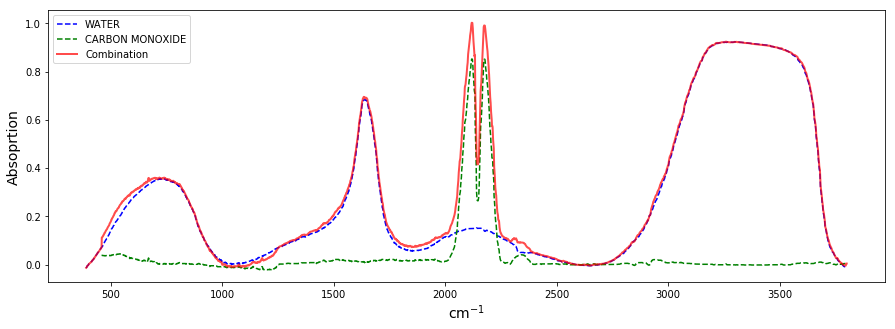

In [3]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

In [4]:
# Exploring a basic example from lmfit documentation
import lmfit
import numpy as np
x = np.linspace(0.3, 10, 100)
np.random.seed(0)
y = 1/(0.1*x) + 2 + 0.1*np.random.randn(x.size)
pars = lmfit.Parameters()
pars.add_many(('a', 0.1), ('b', 1))
def residual(p):
    return 1/(p['a']*x) + p['b'] - y

In [5]:
# Running a fit 
mini = lmfit.Minimizer(residual,pars)
result = mini.minimize()
print(mini.leastsq())
print(lmfit.fit_report(result.params))

[[Variables]]
    a:  0.09943896 +/- 1.9322e-04 (0.19%) (init = 0.1)
    b:  1.98476945 +/- 0.01222678 (0.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.601


In [6]:
# Getting a basic confidence interval
ci = lmfit.conf_interval(mini,result)
lmfit.printfuncs.report_ci(ci)

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a:  -0.00059  -0.00039  -0.00019   0.09944  +0.00019  +0.00039  +0.00060
 b:  -0.03766  -0.02478  -0.01230   1.98477  +0.01230  +0.02478  +0.03761


In [7]:
# using quantiles got the sigmas and using the trace

In [8]:
#Bootstrapping is also an option

Now we look at a problem where calculating the error from approximated covariance can lead to misleading result – two decaying exponentials. In fact such a problem is particularly hard for the Levenberg-Marquardt method, so we first estimate the results using the slower but robust Nelder-Mead method, and then use Levenberg-Marquardt to estimate the uncertainties and correlations.

In [35]:
#function calculates distance start
def peak_1D_score(rowA,rowB,scoremax=1):
    "docstring"
    scores = []
    peaks=[]
    #calculate distance between peaks
    #√((x1-x2)^2 + (y1-y2)^2)

    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = np.where((rowA[i] - rowB[j]>50),np.nan,math.sqrt(sum([math.pow(rowA[i] - rowB[j], 2)])))
            if (1/(distance + 1)>.05):
                scores.append(((1/(distance + 1))/scoremax))
                peaks.append((rowA[i],rowB[j]))

    return scores,peaks
def score_sort(list_input, row,scoremax=1):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list):  input list to iterate
        row (list): input list

    Returns:
        sorteddistances (list): sorted Euclidean distances
    """
    sorteddistances = []
    for index_i in range(len(list_input)):
        #sorteddistances.append((peak_1D_score(row, list_input[index_i],scoremax),index_i))
        sorteddistances.append(peak_1D_score(list_input[index_i],row,max(peak_1D_score(list_input[index_i],row,1)[0][:])))
    sorteddistances.sort()
    return sorteddistances

In [10]:
compound_1 = shoyu_data_dict['WATER']
x_water = compound_1['x']
y_water = compound_1['y']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
x_co = compound_1['x']
y_co = compound_1['y']
compound_3 = shoyu_data_dict['CARBON DIOXIDE']
x_co2 = compound_1['x']
y_co2 = compound_1['y']
peaks_centers1 = spectrafit.compound_report(compound_1)
peaks_centers2 = spectrafit.compound_report(compound_2) 
peaks_centers3 = spectrafit.compound_report(compound_3) 
centerlist= [peaks_centers1,peaks_centers2,peaks_centers3]

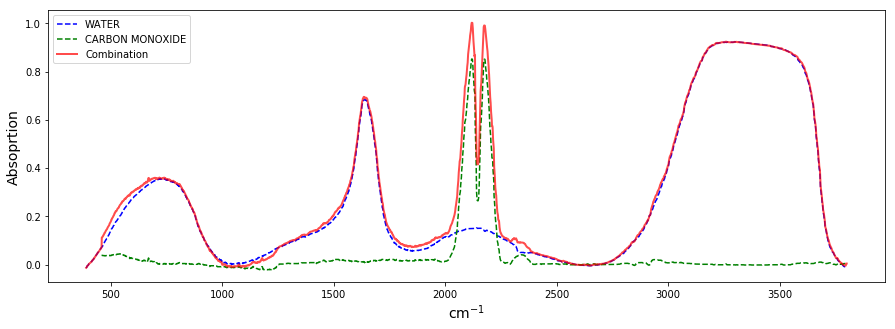

In [11]:
combined_x12,combined_y12 = shoyu.combine_spectra(compound_1,compound_2, plot = True)

In [36]:
data_peaks_combine12 = spectrafit.data_report(combined_x12,combined_y12)
peak_1D_score(peaks_centers1,data_peaks_combine12,max(peak_1D_score(peaks_centers1,data_peaks_combine12,1)[0][:]))

([0.2607316955355646, 1.0],
 [(711.4826030832157, 708.0), (1638.6886199554203, 1638.5198632531205)])

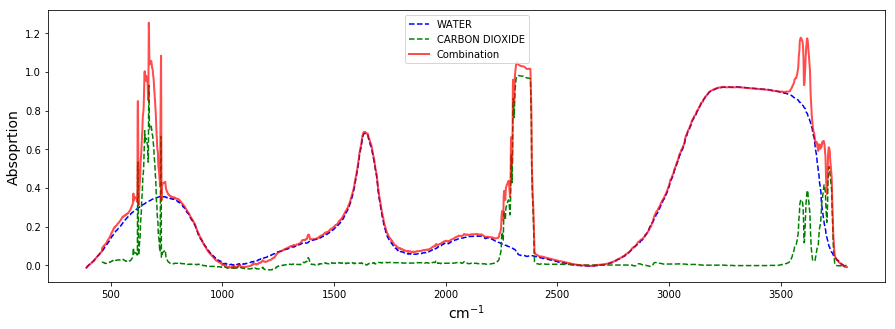

In [13]:
combined_x13,combined_y13  = shoyu.combine_spectra(compound_1, compound_3, plot = True)

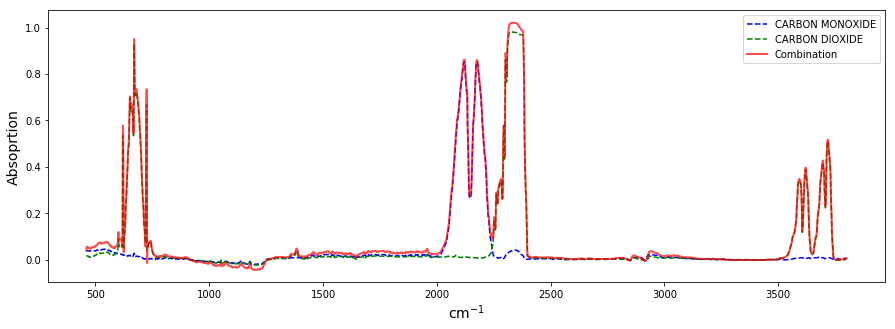

In [14]:
combined_x23,combined_y23  = shoyu.combine_spectra(compound_2, compound_3, plot = True)

In [15]:
data_peaks_combine12 = spectrafit.data_report(combined_x12,combined_y12)
data_peaks_combine13 = spectrafit.data_report(combined_x13,combined_y13)
data_peaks_combine23 = spectrafit.data_report(combined_x23,combined_y23)
combinedlist=[data_peaks_combine12,data_peaks_combine13,data_peaks_combine23]

In [37]:
data=score_sort(centerlist,combinedlist[0],1)
print(data)

[([0.2607316955355646, 1.0], [(711.4826030832157, 708.0), (1638.6886199554203, 1638.5198632531205)]), ([1.0], [(723.8750859253754, 708.0)]), ([1.0, 0.7317475924111191], [(2109.8548231081886, 2110.0000000000095), (2183.58416497579, 2184.149153919652)])]


In [17]:
data=score_sort(centerlist,combinedlist[1],1)
print(data)

[([], 1), ([((611.000000000001, 620.6820993063426), 0.0936145575248806), ((652.0861593999174, 652.1156598823245), 0.9713448581023105), ((679.999999892973, 680.3282599999995), 0.7528645893300575), ((734.9999999999991, 723.8750859253754), 0.08247481127251091), ((2311.999999999999, 2304.1651179999994), 0.11318770301629828), ((2328.999999999997, 2336.8755009789434), 0.11266969632160326), ((3581.0013861296484, 3590.9856357827366), 0.09103944571387719), ((3609.0, 3590.9856357827366), 0.05259181893087368), ((3609.0, 3621.8934979836718), 0.07197611437920413), ((3706.0000000000005, 3692.2514877580816), 0.0678034491613164), ((3706.0000000000005, 3720.4308850577695), 0.06480509680788052)], 2), ([((1638.7961315272316, 1638.6886199554203), 0.9029251029535798)], 0)]


In [18]:
data=score_sort(centerlist,combinedlist[2],1)
print(data)

[([((621.0442289082655, 620.6820993063426), 0.7341445326408823), ((651.8072355339556, 652.1156598823245), 0.7642780427057861), ((679.9999999999992, 680.3282599999995), 0.7528646499930308), ((724.52234753581, 723.8750859253754), 0.6070681145395971), ((2308.7085930807248, 2304.1651179999994), 0.1803922603489283), ((2338.999999970375, 2336.8755009789434), 0.3200513115037985), ((3591.1759676550155, 3590.9856357827366), 0.8401018432662083), ((3622.0652181439837, 3621.8934979836718), 0.8534460990530406), ((3692.2127027246315, 3692.2514877580816), 0.9626630802320802), ((3720.6376840597777, 3720.4308850577695), 0.828638404851114)], 2), ([((724.52234753581, 711.4826030832157), 0.07122636764340956)], 0), ([((2112.000000000002, 2109.8548231081886), 0.3179471407802109), ((2182.7770407196494, 2183.58416497579), 0.5533653796091095)], 1)]


In [53]:
# you will need to download the file yourself from the team google drive and edit location
df = pd.read_excel('../examples/FormicAcid_3percentconc_400C_5s_00000.xlsx', names=('x', 'y'))

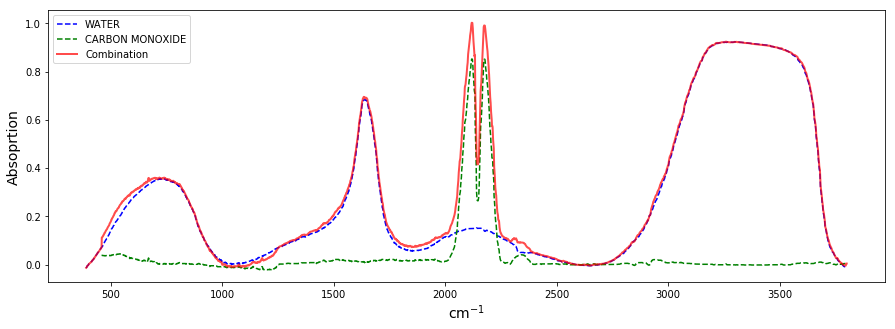

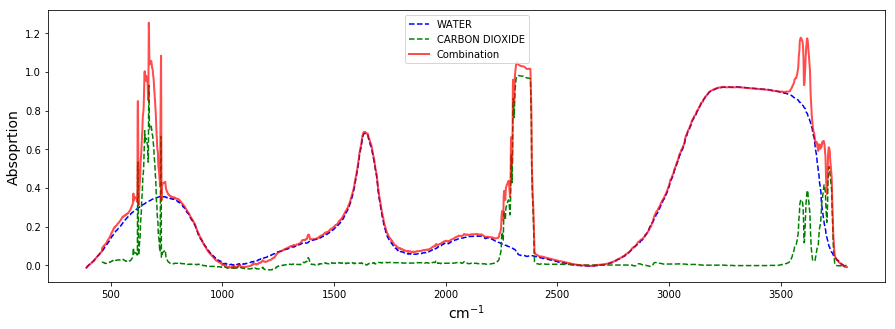

In [54]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
compound_3 = shoyu_data_dict['ETHYL ALCOHOL']
compound_4 = shoyu_data_dict['FORMIC ACID']
compound_5 = shoyu_data_dict['CARBON DIOXIDE']
H2O_CO_x, H2O_CO_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)
H2O_CO2_x, H2O_CO2_y = shoyu.combine_spectra(compound_1, compound_5, plot = True)

In [55]:
H2O_CO_x = np.asarray(H2O_CO_x)
H2O_CO_y = np.asarray(H2O_CO_y)
H2O_CO2_x = np.asarray(H2O_CO2_x)
H2O_CO2_y = np.asarray(H2O_CO2_y)

In [59]:
water_peaks = spectrafit.compound_report(compound_1)[0]
co_peaks = spectrafit.compound_report(compound_2)[0]
co2_peaks = spectrafit.compound_report(compound_5)[0]
H2O_CO_peaks = spectrafit.data_report(H2O_CO_x, H2O_CO_y)[0]
print(H2O_CO_peaks)
H2O_CO2_peaks = spectrafit.data_report(H2O_CO2_x, H2O_CO2_y)[0]


708.0


In [60]:
print(H2O_CO2_peaks)

611.000000000001


IndexError: invalid index to scalar variable.

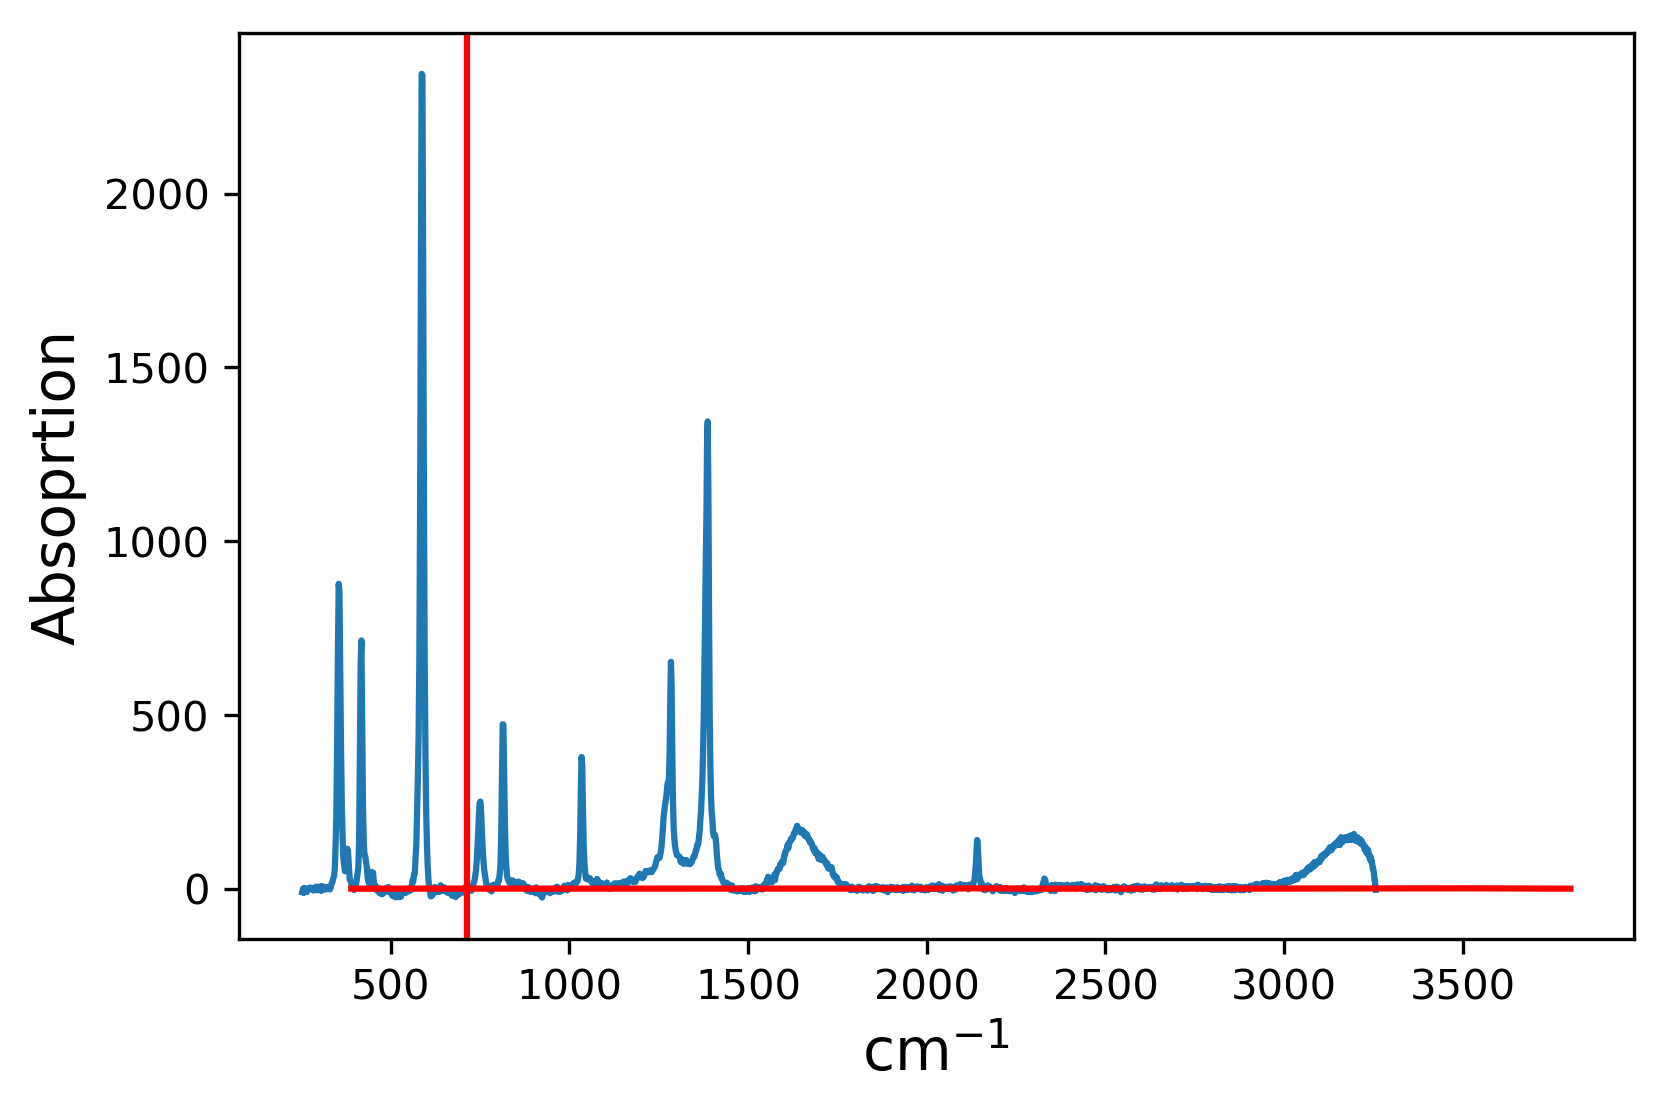

In [57]:
fig = plt.figure(figsize=(6,4), dpi = 300)
plt.plot(x_data, y_data, label ='Experimental')
plt.plot(H2O_CO_x, H2O_CO_y, color = 'red', label = 'Sample Spectra')
plt.xlabel('cm$^{-1}$', fontsize=14)
plt.ylabel('Absoprtion', fontsize=14)
plt.axvline(x =714, color = 'red', label = 'CO2 Peaks')
plt.axvline(x = H2O_CO_peaks[2], color = 'green', label='Reference Peak')
plt.axvline(x = H2O_CO_peaks[2]+10, color = 'green', linestyle='--', label='Sample Peak')
plt.axvline(x = H2O_CO_peaks[3], color = 'green')
plt.axvline(x = H2O_CO_peaks[3]-9, color = 'green', linestyle='--')
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
plt.ylabel('Counts (Normalized)', fontsize=12)
plt.ylim(0.2,2000)
plt.xlim(0, 3500)
plt.legend(loc=1, framealpha=1)

In [41]:
Exp_peaks = [355,379,418,587,712,751,814,1034,1219,1272,1383,1400,1640,2138,2943,3185]

Text(0, 0.5, 'Counts (Normalized)')

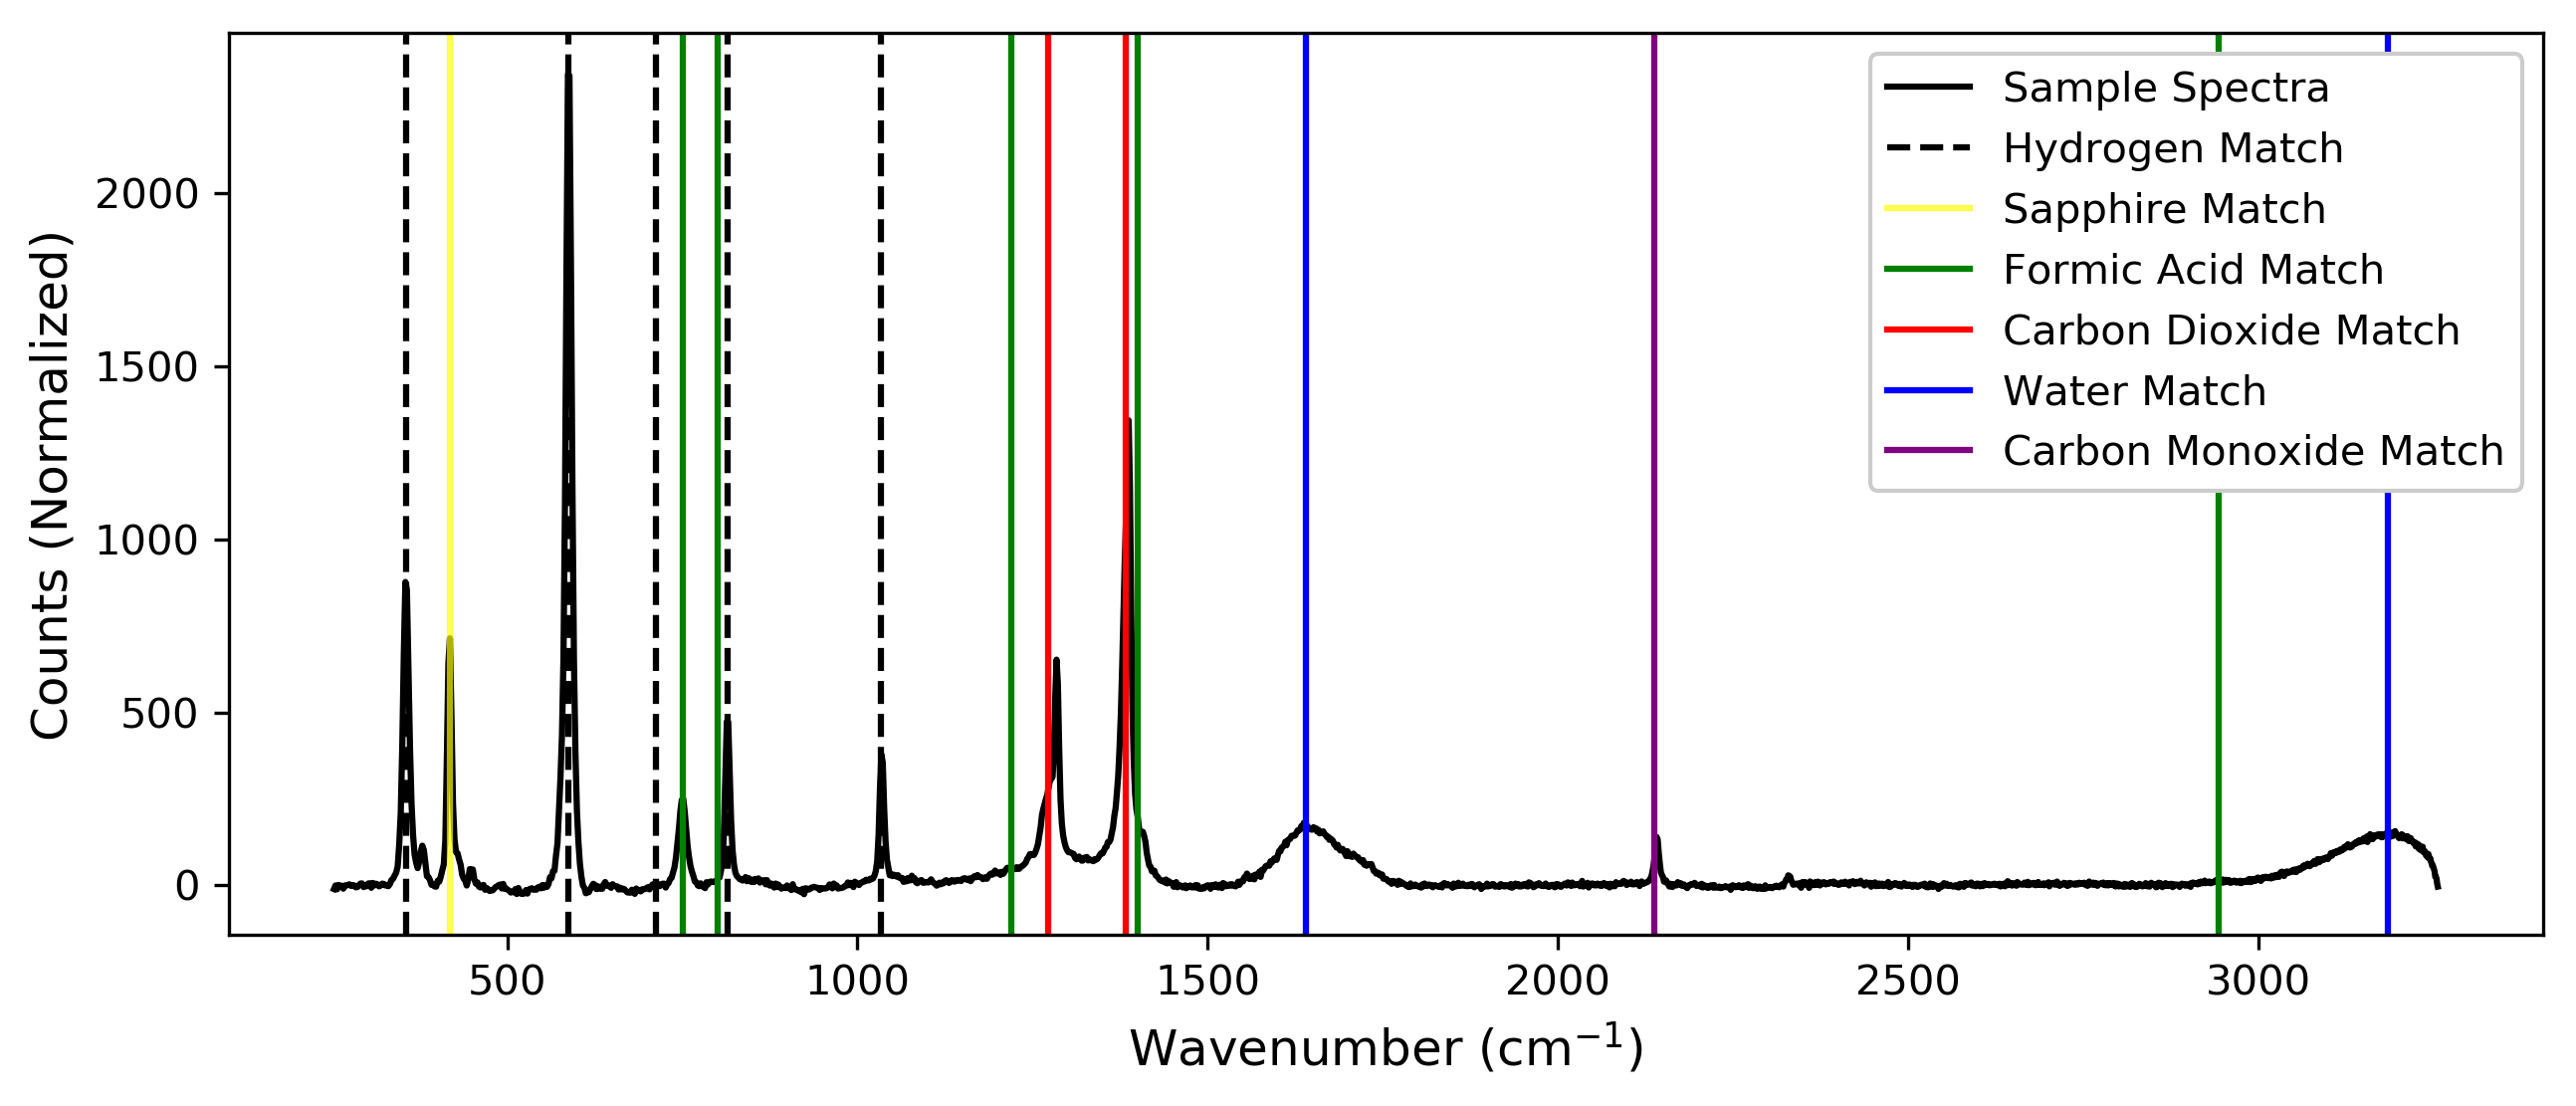

In [42]:
#Ok, now that we have which peaks belong to which component, we'll need to plot their position.
fig = plt.figure(figsize=(10,4), dpi = 300)
plt.plot(x_data, y_data, color = 'black', label = 'Sample Spectra')
plt.axvline(x = Exp_peaks[0], color = 'black', label = 'Hydrogen Match',linestyle='--')
#plt.axvline(x = Exp_peaks[1], color = 'yellow',alpha=.7)
plt.axvline(x = Exp_peaks[2], color = 'yellow', label = 'Sapphire Match',alpha=.7)
plt.axvline(x = Exp_peaks[3], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[4], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[5], color = 'green', label = 'Formic Acid Match')
plt.axvline(x = Exp_peaks[5]+50, color = 'green')
plt.axvline(x = Exp_peaks[6], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[7], color = 'black', linestyle='--')
plt.axvline(x = Exp_peaks[8], color = 'green')
plt.axvline(x = Exp_peaks[9], color = 'red', label = 'Carbon Dioxide Match')
plt.axvline(x = Exp_peaks[10], color = 'red')
plt.axvline(x = Exp_peaks[11], color = 'green')
plt.axvline(x = Exp_peaks[12], color = 'blue',label = 'Water Match')
plt.axvline(x = Exp_peaks[13], color = 'purple', label = 'Carbon Monoxide Match')
plt.axvline(x = Exp_peaks[14], color = 'green')
plt.axvline(x = Exp_peaks[15], color = 'blue')
plt.legend(loc=1, framealpha=1)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
plt.ylabel('Counts (Normalized)', fontsize=12)
#plt.ylim(-0.1, 1.3)
# plt.ylim()
    
#     plt.axvline(x=H2O_CO_x[i], color='orange')
# plt.savefig('matching_plot.png')